In [50]:
import requests
import urllib.request
import os
import time
import sklearn
from sklearn import metrics
import tensorflow as tf
import tensorflow_hub as hub

keras_version = tf.keras.__version__

if keras_version.split('.')[0] == '3':
    import tf_keras as keras
else:
    keras = tf.keras

from keras import layers
from keras.preprocessing import image_dataset_from_directory

from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

In [51]:
tf_seed =tf.random.set_seed(42)
np_seed = np.random.seed(42)
random_seed = random.seed(42)

In [69]:
datapath = r"/content/drive/MyDrive/Data/Data"

In [70]:
def check_img_format(path: str):

    pathfiles = []

    for dir, subdir, files in os.walk(path):
        for file in files:
            pathfiles.append(os.path.join(dir, file))

    for f in pathfiles:
        img = Image.open(f)
        if img.mode != 'RGB':
            img = img.convert('RGB')
        else:
            continue

    print('All images are converted to RGB format.')

check_img_format(datapath)

All images are converted to RGB format.


In [71]:
shuffle_val = True
val_split = 0.2
img_size = (224, 224)
input_shape = (224, 224, 3)
dataset_seed = 32

ds_train = tf.keras.preprocessing.image_dataset_from_directory(
            directory = datapath,
            labels = 'inferred',
            label_mode = 'categorical',
            batch_size = 32,
            image_size = img_size,
            shuffle = shuffle_val,
            seed = dataset_seed,
            validation_split = val_split,
            subset = 'training',
            interpolation = 'nearest'
)

ds_val = tf.keras.preprocessing.image_dataset_from_directory(
            directory = datapath,
            labels = 'inferred',
            label_mode = 'categorical',
            batch_size = 32,
            image_size = img_size,
            shuffle = shuffle_val,
            seed = dataset_seed,
            validation_split = val_split,
            subset = 'validation',
            interpolation = 'nearest'
    )

Found 414 files belonging to 2 classes.
Using 332 files for training.
Found 414 files belonging to 2 classes.
Using 82 files for validation.


In [74]:
classes = tuple([c.replace('_', ' ').capitalize() for c in ds_train.class_names])

print(f'The {len(classes)} classes are: ')
for c in classes:
    print(c)

The 2 classes are: 
Bpmonitor
Glucometer


In [75]:
def img_to_float(img, label):
    img = tf.image.convert_image_dtype(img, dtype= tf.float32)
    return img, label

autotune = tf.data.experimental.AUTOTUNE

In [76]:
ds_train = (ds_train.map(img_to_float).cache().prefetch(buffer_size = autotune))

ds_val = (ds_val.map(img_to_float).cache().prefetch(buffer_size = autotune))

In [77]:
def show_training(training_history):

    model_history = pd.DataFrame(training_history.history)


    loss_plot = model_history.loc[:, ['loss', 'val_loss']].plot()
    loss_plot.set_title('Loss trend for training and validation sets')
    loss_plot.set_ylabel('Loss')
    loss_plot.set_xlabel('Epochs number')
    loss_plot.legend(['Train', 'Validation'])


    acc_plot = model_history.loc[:, ['categorical_accuracy', 'val_categorical_accuracy']].plot()
    acc_plot.set_title('Accuracy value for training and validation sets')
    acc_plot.set_ylabel('Accuracy')
    acc_plot.set_xlabel('Epochs number')
    acc_plot.legend(['Train', 'Validation'])


    arrowprops = {'width': 0.2, 'headwidth': 4, 'headlength': 4, 'shrink': 1}

    train_loss = model_history['loss'].tail(1).values[0]
    validation_loss = model_history['val_loss'].tail(1).values[0]

    train_accuracy = model_history['categorical_accuracy'].tail(1).values[0]
    validation_accuracy = model_history['val_categorical_accuracy'].tail(1).values[0]



    loss_note = f'Train loss reached: {train_loss:.2f}'
    xy_loss_coord = (model_history['loss'].tail(1).index[0], train_loss)
    loss_plot.annotate(text = loss_note, xytext = (20, 0.45), xy = xy_loss_coord, arrowprops= arrowprops)

    loss_val_note = f'Validation loss reached: {validation_loss:.2f}'
    xy_lossval_coord = (model_history['val_loss'].tail(1).index[0], validation_loss)
    loss_plot.annotate(text = loss_val_note, xytext = (20, 0.5), xy = xy_lossval_coord, arrowprops= arrowprops)


    acc_note = f'Train accuracy reached: {train_accuracy:.2f}'
    xy_acc_coord = (model_history['categorical_accuracy'].tail(1).index[0], train_accuracy)
    acc_plot.annotate(text = acc_note, xytext = (20, 0.85), xy = xy_acc_coord, arrowprops= arrowprops)


    acc_val_note = f'Validation accuracy reached: {validation_accuracy:.2f}'
    xy_accval_coord = (model_history['val_categorical_accuracy'].tail(1).index[0], validation_accuracy)
    acc_plot.annotate(text = acc_val_note, xytext = (20, 0.8), xy = xy_accval_coord, arrowprops= arrowprops)

    print(model_history['loss'].tail(1).index, model_history['loss'].tail(1), model_history['loss'].tail(1).index[0])

In [78]:
import tensorflow as tf
import tensorflow_hub as hub

effnet_b7_url = "https://tfhub.dev/tensorflow/efficientnet/b7/feature-vector/1"

base_effnet = hub.KerasLayer(
    effnet_b7_url,
    input_shape=(224, 224, 3),
    trainable=False
)


In [79]:
model_effnet = keras.Sequential([
    base_effnet,
    keras.layers.Dense(2, activation='softmax')
])

In [80]:
model_effnet.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_3 (KerasLayer)  (None, 2560)              64097680  
                                                                 
 dense_5 (Dense)             (None, 2)                 5122      
                                                                 
Total params: 64102802 (244.53 MB)
Trainable params: 5122 (20.01 KB)
Non-trainable params: 64097680 (244.51 MB)
_________________________________________________________________


In [81]:
model_effnet.compile( optimizer= 'adam',
                    loss = 'categorical_crossentropy',
                    metrics = ['categorical_accuracy'],

)

early_stopping = keras.callbacks.EarlyStopping(
    patience = 10,
    min_delta = 0.001,
    restore_best_weights = True
)

In [82]:
history_effnet = model_effnet.fit(
    ds_train,
    validation_data = ds_val,
    batch_size = 32,
    epochs = 5,
    callbacks = [early_stopping],
    verbose = 0
)

RangeIndex(start=4, stop=5, step=1) 4    0.167971
Name: loss, dtype: float64 4


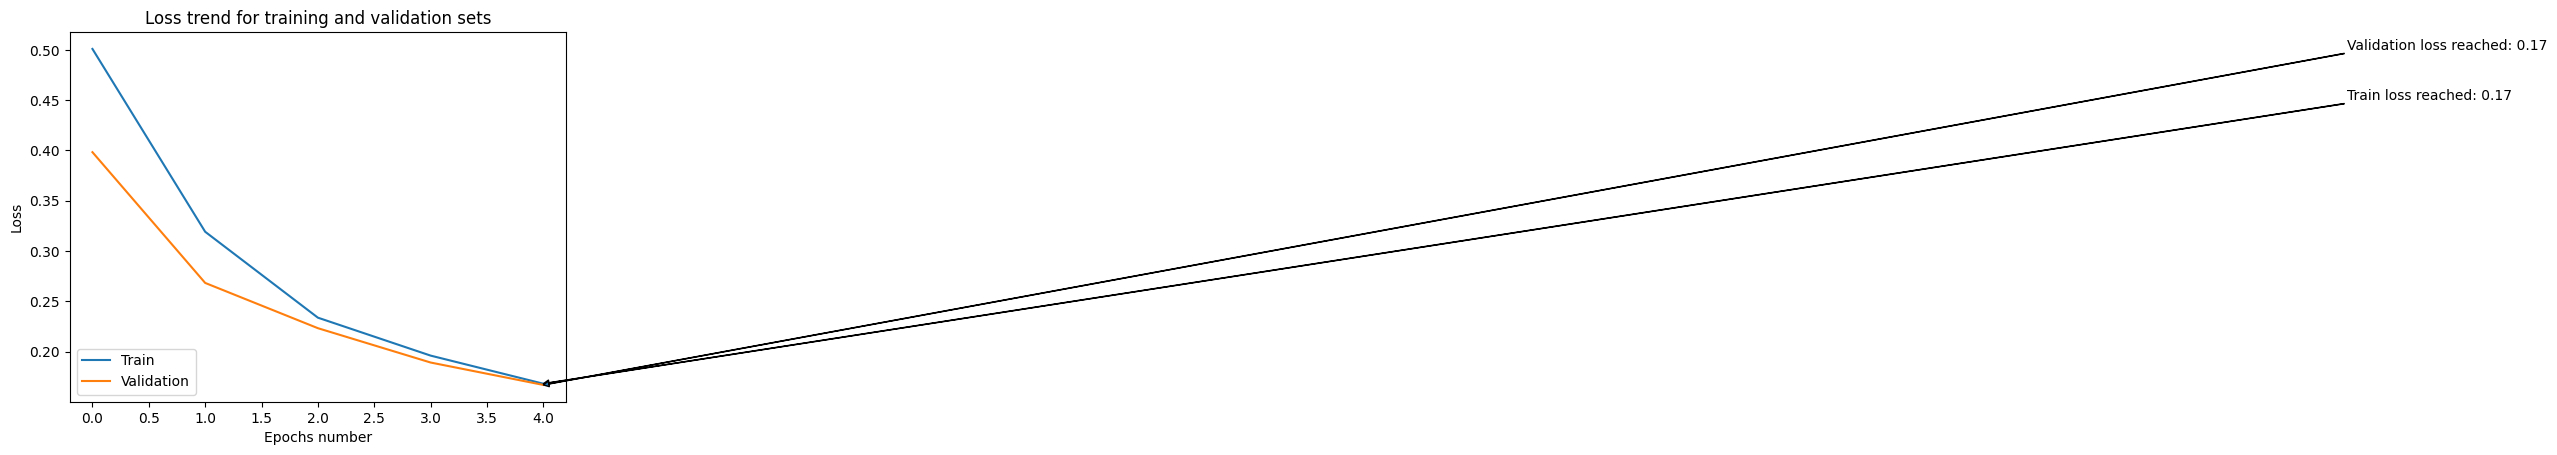

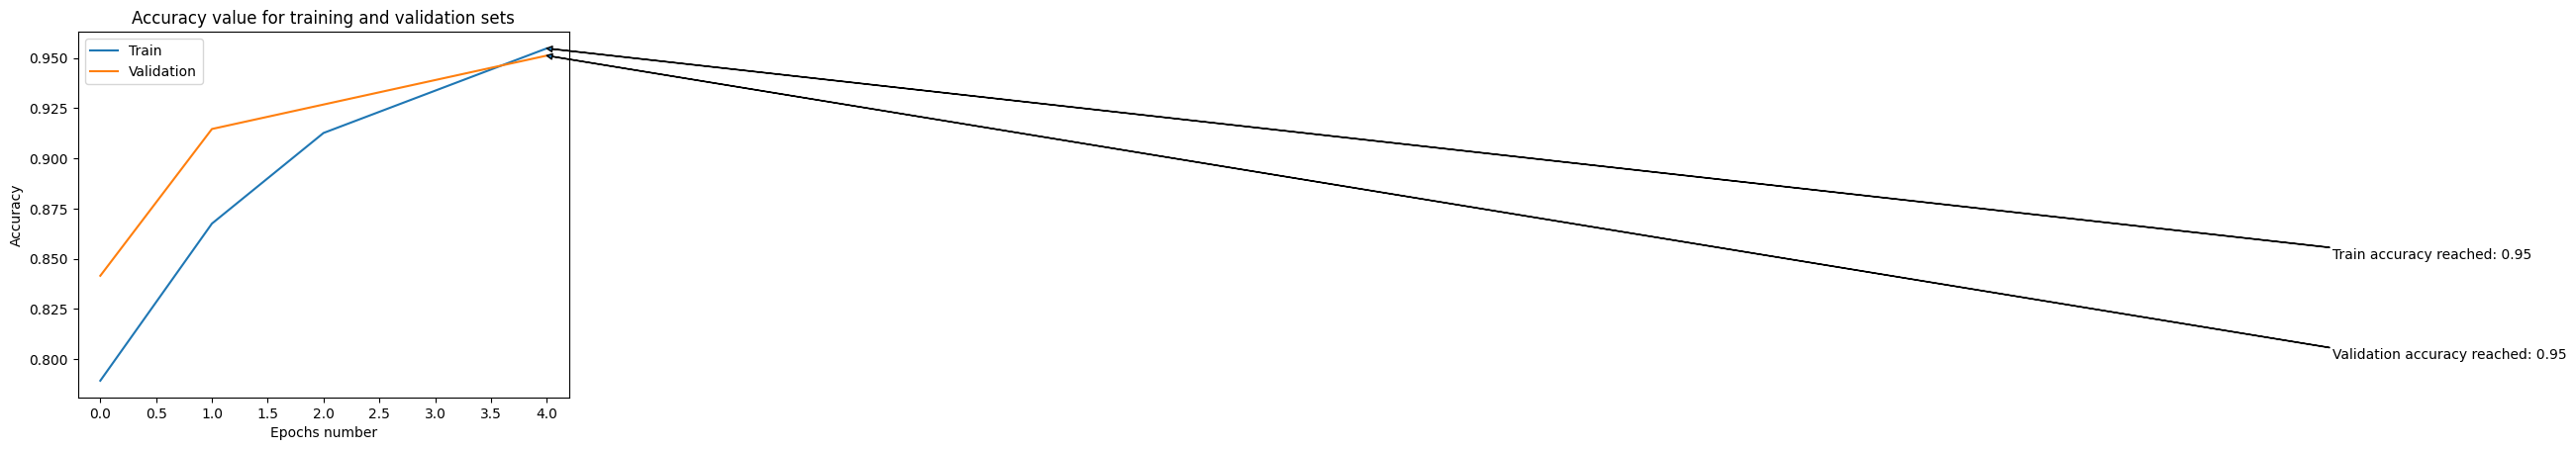

In [83]:
show_training(history_effnet)

In [84]:
effnet_val_true = [label for _, label in ds_val]

effnet_val_predict = model_effnet.predict(ds_val)

3/3 [==============================] - 27s 7s/step


In [85]:
def y_classes_values(y_values) -> list:

    classes_y = []

    for arr in y_values:
        argmax = np.argmax(arr, axis = 0)
        argmax = int(argmax)
        classes_y.append(argmax)

    return classes_y

In [86]:
predicted_classes = y_classes_values(effnet_val_predict)
print('Predicted classes: \n')
print(predicted_classes)
print(f'List length: {len(predicted_classes)} \n\n')

true_values_batches = [batch.numpy() for batch in effnet_val_true]
true_values = np.concatenate(true_values_batches, axis = 0)

true_classes = y_classes_values(true_values)

print('Actual classes: \n')
print(true_classes)
print(f'List length: {len(true_classes)}')

Predicted classes: 

[0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1]
List length: 82 


Actual classes: 

[0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1]
List length: 82


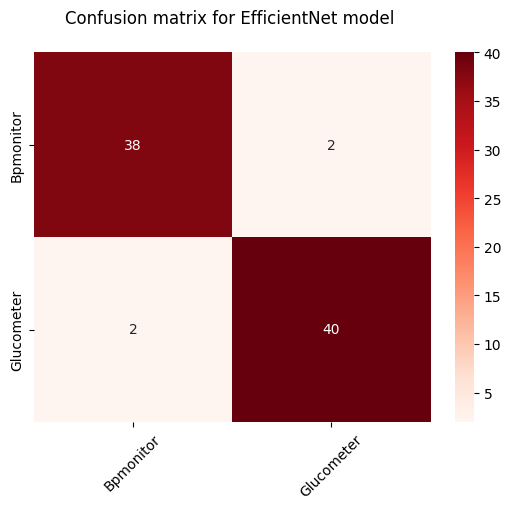

In [87]:
confusion_matrix = metrics.confusion_matrix(true_classes, predicted_classes)

adj_classes = list(map(lambda x: x.lower().capitalize() ,classes))
cm_plot = sns.heatmap(confusion_matrix, annot = True, fmt= 'd', cmap= 'Reds', xticklabels = adj_classes, yticklabels= adj_classes)
cm_plot.tick_params(axis='x', rotation=45)
cm_plot.set_title('Confusion matrix for EfficientNet model \n')
plt.show()